## Circumplanetary Disk - Create a Simple Mock Model

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Import some astronomical constants
from astropy.constants import M_sun, L_sun, R_sun, au, pc, G, M_jup, R_jup
from astropy.units import K, g, cm


# Convert constants to cgs units
au = au.cgs.value     # Astronomical Unit       [cm]
pc = pc.cgs.value     # Parsec                  [cm]
M_sun = M_sun.cgs.value  # Solar mass              [g]
T_sun = 3000      # Solar temperature       [K]
L_sun = L_sun.cgs.value  # Solar luminosity        [erg/s]
R_sun = R_sun.cgs.value  # Solar radius            [cm]
M_jup = M_jup.cgs.value  # Jupiter mass            [g]
R_jup = R_jup.cgs.value  # Jupiter radius          [cm]   


# Add grid refinement before making the coordinates
# add additional points between existing points
# nspan: The number of points from the start of the array to consider for refinement.
# midplane has mirror symmetry, so only need to refine one side
def grid_refine_mid_plane(theta_orig, nlev, nspan):
    theta = theta_orig.copy()
    rev = theta[0] > theta[1]
    for ilev in range(nlev):
        #theta_new = 0.5 * (theta[nspan-1:-1] + theta[nspan:])  #for last few indices-> small z, refine midplane
        theta_new = 0.5 * (theta[1:nspan+1] + theta[:nspan])   # #refine disk surface
        theta_ref = np.hstack((theta, theta_new))
        theta_ref.sort()
        theta = theta_ref
        if rev:
            theta = theta[::-1]
    return theta

# if want to find gird_refinement in phi, go back to model 8


nlev_thetain = 4 
nspan_thetain= 3  


# Define the parameters of the model

    # radmc3d.inp parameter : main settings for RADMC-3D
nphot    = 1e8  #for the thermal monte carto simulation
nphot_scat = 1e7  #for the scattering monte carto simulation
#multiple CPU cores, may need cluster

    # Grid : defines layout of space

# number go back to CPD_simple_1_test_no_planet_grid_refinement
nr       = 150 
ntheta   = 80
nphi     = 117


# Radius for PPD not CPD
# r:  inner CPD (0.2 au to 2.2 au) , gap (2.2 au to 26 au) , outer dust ring (26 au to 90 au)
# (Poblette et al 2022), but doesnt include the inner CPD rim, prob need calculagte truncation radius from star mass
# CPD locates 37.2 au away from star (r = 37.2 )
r_in      = 0.2*au   # 3 times Jupyter radius
r_out     = 90*au 

theta_up  = np.pi*0.5 - 0.7e0  
        # Coordinate array
r_i       = np.linspace(r_in,r_out,nr+1)
#r_i       = np.logspace(np.log10(r_in),np.log10(r_out),nr+1)  #+1 because it is not counting cell centers, but the walls
#r_i       = grid_refine_inner_edge(r_i,nlev_rin,nspan_rin)

theta_i   = np.linspace(theta_up,0.5e0*np.pi,ntheta+1)  # theta goes to pi/2 lets z starts from zero 

theta_i   = grid_refine_mid_plane(theta_i, nlev_thetain, nspan_thetain)


print(np.pi/2.e0-theta_i)
phi_i     = np.linspace(0.e0,np.pi*2.e0,nphi+1)



        # Cell center position array

r_c       = 0.5 * ( r_i[:-1] + r_i[1:] )
theta_c   = 0.5 * ( theta_i[:-1] + theta_i[1:] )
phi_c     = 0.5 * ( phi_i[:-1] + phi_i[1:] )

ntheta       = len(theta_c)  
nphi         = len(phi_c)

print( f'the number of phi grid cells are {nphi}')
print(f'The number of theta grid cells are {ntheta}')
        # Make the grid
            # takes in the center positions of the cells and returns a 3D matrix of the grid
            # indexing='ij' means that the first two indices of the 3D matrix are the r and theta coordinates
qq       = np.meshgrid(r_c,theta_c,phi_c,indexing='ij')
            # Extract the coordinates (r,theta, z) from the 3D matrix
rr       = qq[0]  # final r coor defined by cell center
tt       = qq[1] # final theta coor defined by cell center, just for defining zr
pp       = qq[2]
zr       = np.pi/2.e0 - qq[1]    # z = pi/2 - theta, essentially frame rotated by 90 degrees, and z is from 0 to 0.7 radians



    # Density: dust values (for each species) for each cell in the grid
                                                                                                                                                             
        # number of dust species
ndustspec = 2


sigmag0  = 1e3               # Sigma gas at 1 AU
sigmad0  = sigmag0 * 0.01    # Sigma dust at 1 AU
fracbig  = 0.99              # Fraction of dust that is the big grain dust
plsig    = -1.0e0            # Powerlaw of the surface density
hr0      = 0.05              # H_p/r at 1 AU
plh      = 0.1               # Powerlaw of flaring
hrbigsett= 0.02              # The big grains are settled a bit more than the small grains
        # dust density function

sigmad   = sigmad0 * (rr/au)**plsig
sigmadsm = sigmad*(1.-fracbig)
sigmadbg = sigmad*fracbig
hhrsm    = hr0 * (rr/au)**plh
hhrbg    = hrbigsett * (rr/au)**plh
hhsm     = hhrsm * rr
hhbg     = hhrbg * rr
rhodsm   = ( sigmadsm / (np.sqrt(2.e0*np.pi)*hhsm) ) * np.exp(-(zr**2/hhrsm**2)/2.e0)
rhodbg   = ( sigmadbg / (np.sqrt(2.e0*np.pi)*hhbg) ) * np.exp(-(zr**2/hhrbg**2)/2.e0)



#CPD parameters
#sigma_g0 =  10**3 #(g/cm**2)   # gas surface density at 1 au
sigmad02 = 2127 #(g/cm**2) #g/cm^2 # dust surface density at 1 au
plsig2 = -1.2# power law index for the dust surface density
plh2  = 1.15 # power law index for the dust scale height
hr02 = 0.1
hrbigsett2 =0.05

# Make the dust density model for CPD
#
sigmad2  = sigmad02 * (rr/au)**plsig2
sigmadsm2 = sigmad2*(1.-fracbig)
sigmadbg2 = sigmad2*fracbig
hhrsm2    = hr02 *(rr/au)**plh2
hhrbg2    = hrbigsett2 * (rr/au)**plh2
hhsm2     = hhrsm2 * rr
hhbg2     = hhrbg2 * rr
rhodsm2   = ( sigmadsm2 / (np.sqrt(2.e0*np.pi)*hhsm2) ) * np.exp(-(zr**2/hhrsm2**2)/2.e0)
rhodbg2   = ( sigmadbg2 / (np.sqrt(2.e0*np.pi)*hhbg2) ) * np.exp(-(zr**2/hhrbg2**2)/2.e0)

# Define the radial range for the CPD
r_min = 36.2 * au  # Inner radius of the CPD region
r_max = 38.2 * au  # Outer radius of the CPD region
phi_max = np.arctan(1/37.2) # Azimuthal range of the CPD region
phi_min = 2*np.pi - phi_max


# Create a mask for the specified range of rr
mask_r = (rr >= r_min) & (rr <= r_max)
mask_phi = (pp >= 0) & (pp <= phi_max) | (pp >= phi_min) & (pp <= 2*np.pi) #or operator

mask = mask_r & mask_phi

# Extract the masked radial values
r_masked = rr[mask]
pp_masked = pp[mask]

# Define the midpoint of the CPD region
r_mid = 37.2*au # Midpoint of the radial range

# Shift the radial array by the midpoint and take the positive values

r_shifted = np.sqrt(r_masked**2 + r_mid**2 - 2*r_masked*r_mid*np.cos(pp_masked))

# Update the density model within the specified range
# Apply the shifted and positive radial values
# ongoing discussion about shape (Sun etal 2024)
sigmad[mask] += sigmad02 * (r_shifted / au) ** plsig2
sigmadsm[mask] = sigmad[mask] * (1. - fracbig)
sigmadbg[mask] = sigmad[mask] * fracbig
hhrsm[mask] += hr02 * (r_shifted / au) ** plh2
hhrbg[mask] += hrbigsett2 * (r_shifted / au) ** plh2
hhsm[mask] = hhrsm[mask] * r_shifted
hhbg[mask] = hhrbg[mask] * r_shifted
rhodsm[mask] = (sigmadsm[mask] / (np.sqrt(2.e0 * np.pi) * hhsm[mask])) * np.exp(-(zr[mask] ** 2 / hhrsm[mask] ** 2) / 2.e0)
rhodbg[mask] = (sigmadbg[mask] / (np.sqrt(2.e0 * np.pi) * hhbg[mask])) * np.exp(-(zr[mask] ** 2 / hhrbg[mask] ** 2) / 2.e0)

[0.7        0.69945313 0.69890625 0.69835937 0.6978125  0.69726562
 0.69671875 0.695625   0.69453125 0.6934375  0.69125    0.6890625
 0.686875   0.6825     0.678125   0.67375    0.665      0.65625
 0.6475     0.63875    0.63       0.62125    0.6125     0.60375
 0.595      0.58625    0.5775     0.56875    0.56       0.55125
 0.5425     0.53375    0.525      0.51625    0.5075     0.49875
 0.49       0.48125    0.4725     0.46375    0.455      0.44625
 0.4375     0.42875    0.42       0.41125    0.4025     0.39375
 0.385      0.37625    0.3675     0.35875    0.35       0.34125
 0.3325     0.32375    0.315      0.30625    0.2975     0.28875
 0.28       0.27125    0.2625     0.25375    0.245      0.23625
 0.2275     0.21875    0.21       0.20125    0.1925     0.18375
 0.175      0.16625    0.1575     0.14875    0.14       0.13125
 0.1225     0.11375    0.105      0.09625    0.0875     0.07875
 0.07       0.06125    0.0525     0.04375    0.035      0.02625
 0.0175     0.00875    0.        ]


shape of rr: (150, 92, 117)
shape of r_masked: (552,)
shape of mask: (150, 92, 117)
pp min: 0.026851219261451224, pp max: 6.256334087918136
Indices of True values in mask_phi: (array([  0,   0,   0, ..., 149, 149, 149], shape=(27600,)), array([ 0,  0,  1, ..., 90, 91, 91], shape=(27600,)), array([  0, 116,   0, ..., 116,   0, 116], shape=(27600,)))
Indices of True values in mask_r: (array([60, 60, 60, ..., 62, 62, 62], shape=(32292,)), array([ 0,  0,  0, ..., 91, 91, 91], shape=(32292,)), array([  0,   1,   2, ..., 114, 115, 116], shape=(32292,)))
Total number of True values in mask_r: 32292
Total number of data points in rr: 1614600
Total number of True values in mask_phi: 27600
Total number of data points in pp: 1614600


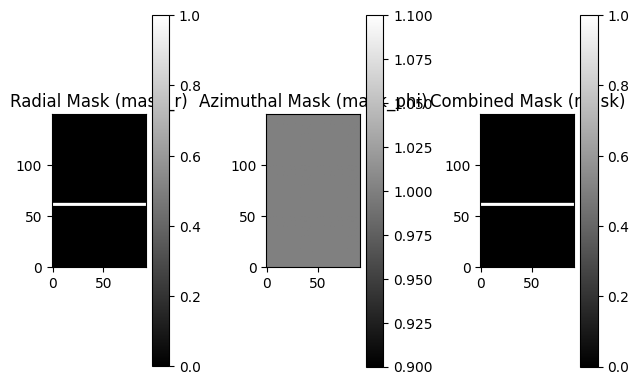

In [11]:


print(f'shape of rr: {rr.shape}')
print(f'shape of r_masked: {r_masked.shape}')
print(f'shape of mask: {mask.shape}')

# Get the indices of the True values in the mask


# Place the masked values into the new array





#mask_phi = (pp >= 0) & (pp <= np.pi)
print(f'pp min: {np.min(pp)}, pp max: {np.max(pp)}')
indices_mask_phi = np.where(mask_phi)
print(f'Indices of True values in mask_phi: {indices_mask_phi}')
indices_mask_r = np.where(mask_r)
print(f'Indices of True values in mask_r: {indices_mask_r}')

print(f'Total number of True values in mask_r: {np.sum(mask_r)}')
print(f'Total number of data points in rr: {rr.size}')
#Print the fraction of data points in the phi mask true compare to total data points of the phi grid, it should be small
print(f'Total number of True values in mask_phi: {np.sum(mask_phi)}')
print(f'Total number of data points in pp: {pp.size}')


import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(mask_r[:, :, 0], cmap='gray', origin='lower')
plt.title('Radial Mask (mask_r)')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(mask_phi[:, :, 0], cmap='gray', origin='lower')
plt.title('Azimuthal Mask (mask_phi)')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(mask[:, :, 0], cmap='gray', origin='lower')
plt.title('Combined Mask (mask)')
plt.colorbar()

plt.tight_layout()
plt.show()




In [12]:
print(r_masked/au)

[36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333 36.41933333
 36.41933333 36.41933333 36.41933333 36.41933333 36

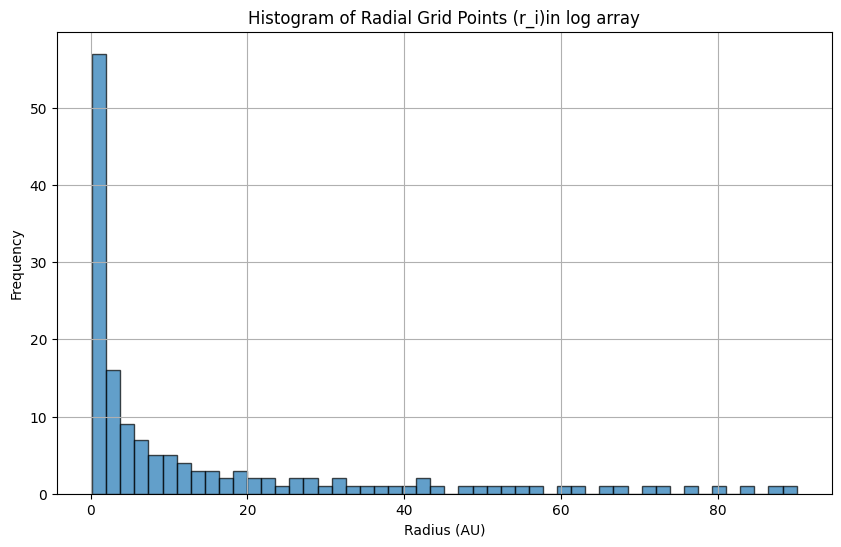

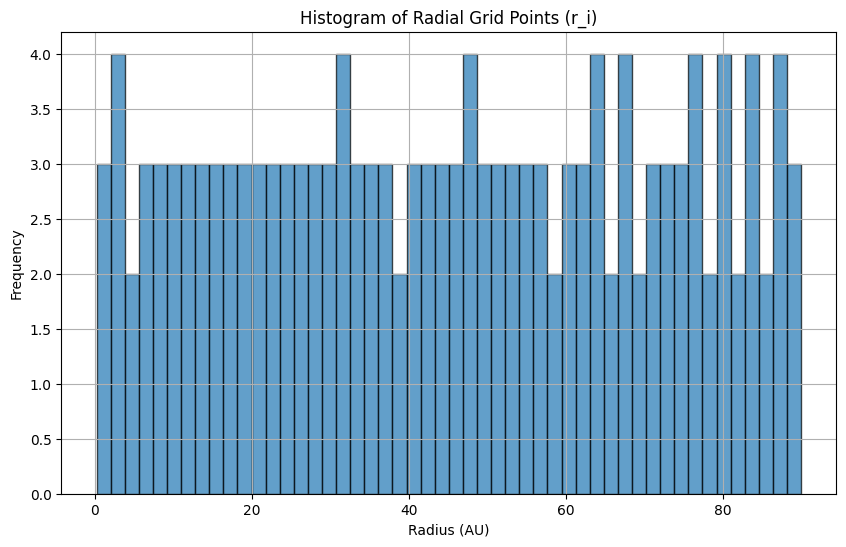

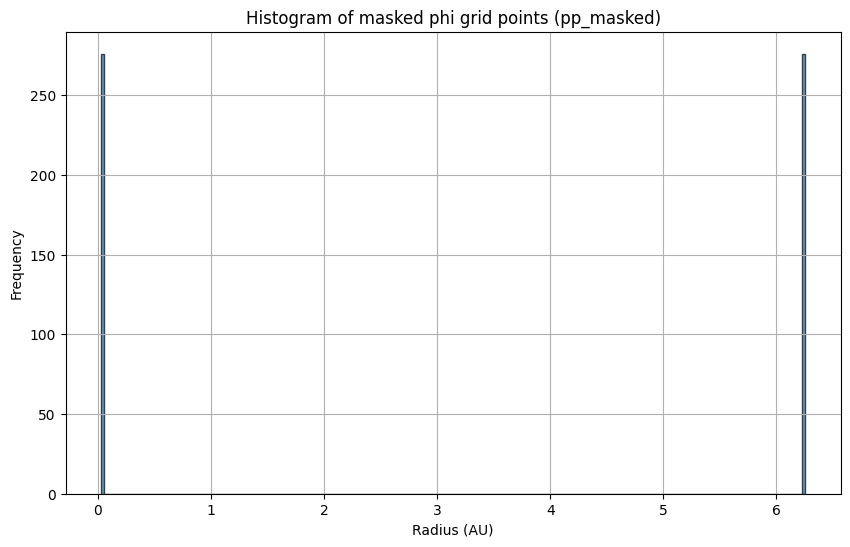

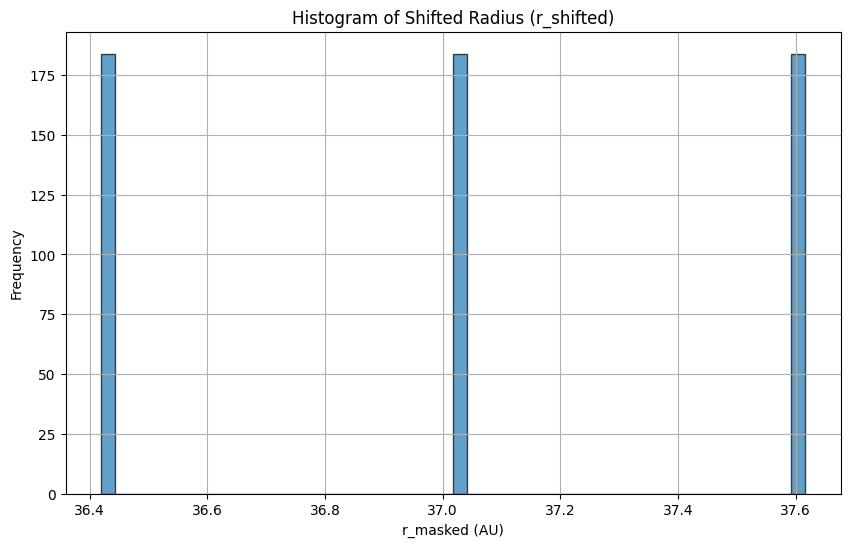

In [13]:

# Plot the histogram for r_i array
r_i_log       = np.logspace(np.log10(r_in),np.log10(r_out),nr+1)
plt.figure(figsize=(10, 6))
plt.hist(r_i_log/au, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Radius (AU)')
plt.ylabel('Frequency')
plt.title('Histogram of Radial Grid Points (r_i)in log array')
plt.grid(True)
plt.show()



# Plot the histogram for r_i
plt.figure(figsize=(10, 6))
plt.hist(r_i/au, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Radius (AU)')
plt.ylabel('Frequency')
plt.title('Histogram of Radial Grid Points (r_i)')
plt.grid(True)
plt.show()


# Plot the histogram for pp_masked (should be two extreme)
plt.figure(figsize=(10, 6))
plt.hist(pp_masked, bins=200, edgecolor='k', alpha=0.7)
plt.xlabel('Radius (AU)')
plt.ylabel('Frequency')
plt.title('Histogram of masked phi grid points (pp_masked)')
plt.grid(True)
plt.show()


# Plot the histogram for r_masked
plt.figure(figsize=(10, 6))
plt.hist(r_masked/au, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('r_masked (AU)')
plt.ylabel('Frequency')
plt.title('Histogram of Shifted Radius (r_shifted)')
plt.grid(True)
plt.show()
# So they are in units of cm, why the values are the same though




In [14]:
print(np.shape(rr))
print(np.shape(r_masked))
print(np.shape(sigmadsm))
print(np.shape(rhodbg))

(150, 92, 117)
(552,)
(150, 92, 117)
(150, 92, 117)


The shape of rr_slice is (150, 117)
The shape of pp_slice is (150, 117)
The shape of sigmad_slice is (150, 117)
The shape of x is (117, 150)
The shape of y is (117, 150)


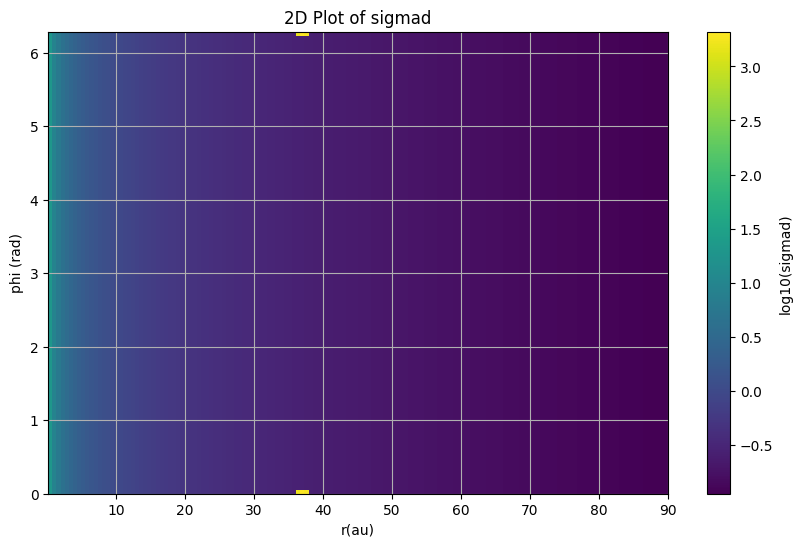

C:\Users\LHEM\AppData\Local\Temp\ipykernel_32400\304931481.py:36: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x/au, y/au, np.log(sigmad_slice.T), shading='auto', cmap='viridis')


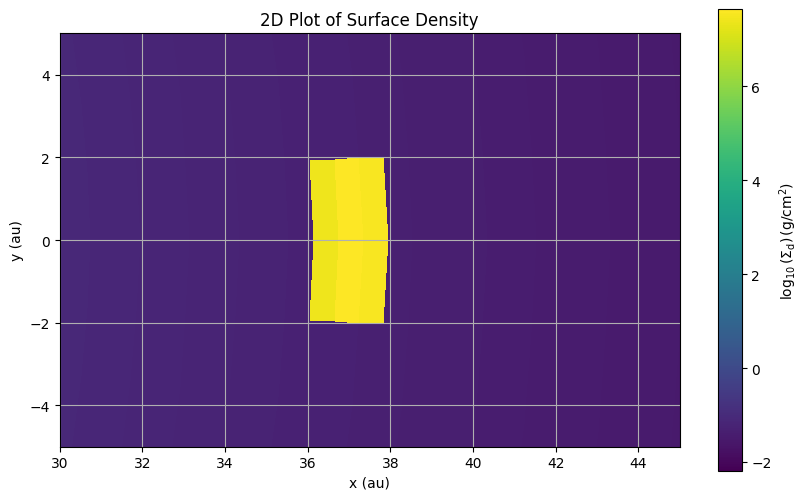

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rr, pp, and sigmad are 3D arrays
# Select the 2D slice where theta is zero (assuming theta is the third dimension)
rr_slice = rr[:, 0, :]
pp_slice = pp[:, 0, :]
sigmad_slice = sigmad[:, 0, :]

print(f'The shape of rr_slice is {np.shape(rr_slice)}')
print(f'The shape of pp_slice is {np.shape(pp_slice)}')
print(f'The shape of sigmad_slice is {np.shape(sigmad_slice)}')


# Create 2D grids for r and phi
r_grid, phi_grid = np.meshgrid(rr_slice[:, 0], pp_slice[0, :])

# Convert polar coordinates (r, phi) to Cartesian coordinates (x, y)
x = r_grid * np.cos(phi_grid)
y = r_grid * np.sin(phi_grid)
print(f'The shape of x is {np.shape(x)}')
print(f'The shape of y is {np.shape(y)}')


# Create a 2D plot of sigmad vs x, y
plt.figure(figsize=(10, 6))
plt.pcolormesh(rr_slice/au, pp_slice, np.log10(sigmad_slice), shading='auto', cmap='viridis')
plt.colorbar(label='log10(sigmad)')
plt.xlabel('r(au)')
plt.ylabel('phi (rad)')
plt.title('2D Plot of sigmad')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.pcolormesh(x/au, y/au, np.log(sigmad_slice.T), shading='auto', cmap='viridis')
plt.colorbar(label=r'$\log_{10}(\Sigma_{\mathrm{d}}) \, (\mathrm{g/cm^2})$')
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.xlim(30,45)
plt.ylim(-5,5)
plt.title('2D Plot of Surface Density')
plt.gca().set_aspect('equal') 
plt.grid(True)
plt.show()

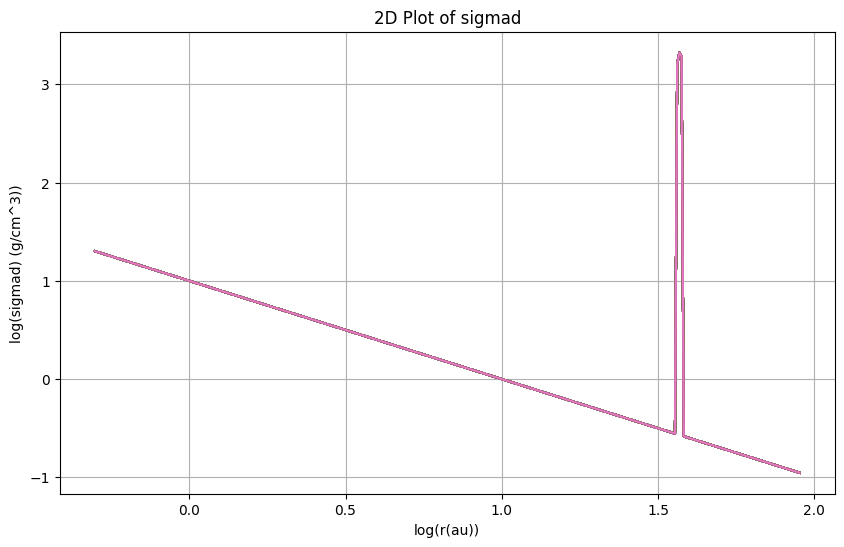

In [16]:
rr_slice = rr[:, 0, :]
pp_slice = pp[:, 0, :]
sigmad_slice = sigmad[:, 0, :]


plt.figure(figsize=(10, 6))
plt.plot(np.log10(rr_slice/au), np.log10(sigmad_slice[:,0]))
plt.xlabel('log(r(au))')
plt.ylabel('log(sigmad) (g/cm^3))')
plt.title('2D Plot of sigmad')
plt.grid(True)
plt.show()



In [17]:
print(np.shape(mask))

(150, 92, 117)


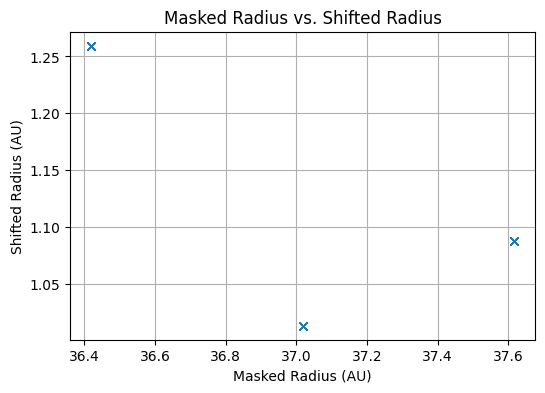

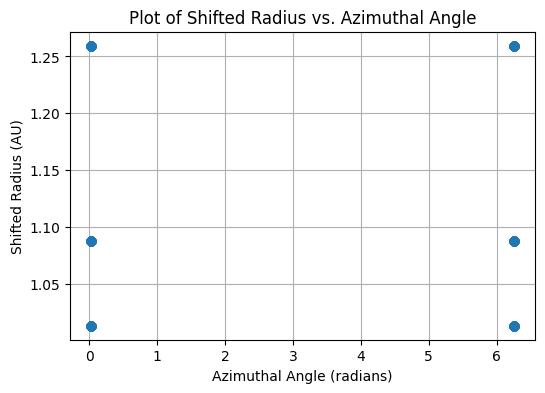

In [18]:
# Focused on the masked region
# What do I want to test -> masked_r and shifted_r 
# what should masked_r and shifted_r look like

r_masked_au = r_masked / au
r_shifted_au = r_shifted / au

# Plot r_masked versus r_shifted
plt.figure(figsize=(6, 4))
plt.plot(r_masked_au, r_shifted_au, 'x')
plt.xlabel('Masked Radius (AU)')
plt.ylabel('Shifted Radius (AU)')
plt.title('Masked Radius vs. Shifted Radius')
plt.grid(True)
plt.show()

# r_shifted vs pp_masked
plt.figure(figsize=(6, 4))
plt.plot(pp_masked,r_shifted_au, 'o')
#plt.xlim(0, np.pi)
plt.ylabel('Shifted Radius (AU)')
plt.xlabel('Azimuthal Angle (radians)')
plt.title('Plot of Shifted Radius vs. Azimuthal Angle')
plt.grid(True)
plt.show()


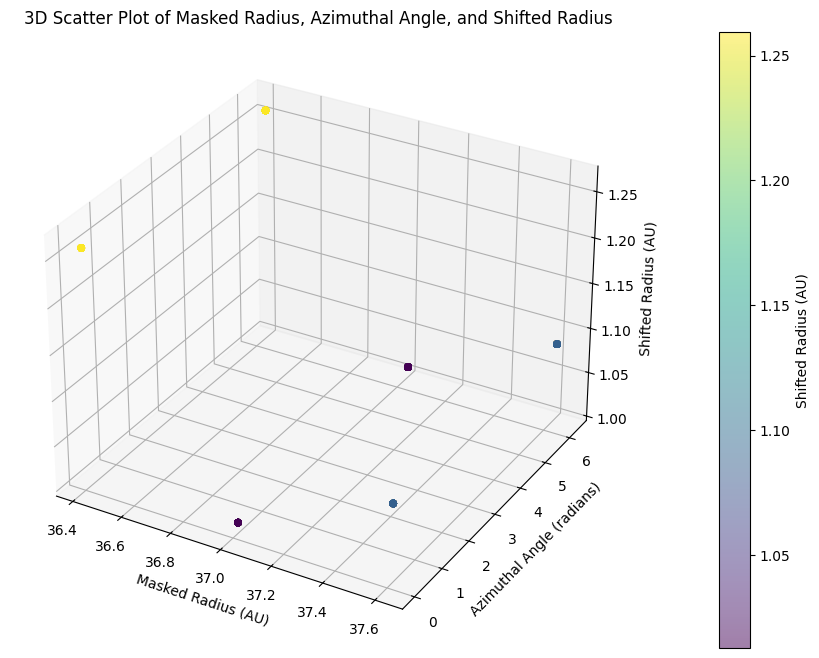

All angles at r = 37.2 au has shifted radius of 1 -> largest dust density  as smallest r
max Angles at 2 or 4 radians can only be reached at r = 37.2 the shifted radius is 1
Range of shifted r: 


In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming r_masked, pp_masked, and r_shifted are already calculated as per your previous code

# Convert r_masked and r_shifted to AU for easier interpretation
r_masked_au = r_masked / au
r_shifted_au = r_shifted / au

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
sc = ax.scatter(r_masked_au, pp_masked, r_shifted_au, c=r_shifted_au, cmap='viridis', s=20, alpha=0.5)

# Add color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Shifted Radius (AU)')

# Set labels
ax.set_xlabel('Masked Radius (AU)')
ax.set_ylabel('Azimuthal Angle (radians)')
ax.set_zlabel('Shifted Radius (AU)')
ax.set_title('3D Scatter Plot of Masked Radius, Azimuthal Angle, and Shifted Radius')

# Show plot
plt.show()


print(f'All angles at r = 37.2 au has shifted radius of 1 -> largest dust density  as smallest r')
print(f'max Angles at 2 or 4 radians can only be reached at r = 37.2 the shifted radius is 1')
print(f'Range of shifted r: ')

In [20]:
print(np.shape(rhodsm))

(150, 92, 117)


In [21]:
def calculate_mean_separation(nphi, radius_au):
    """
    Calculate the mean separation between grid cells in radians and AU.

    Parameters:
    nphi (int): Number of azimuthal grid cells.
    radius_au (float): Radius in astronomical units (AU).

    Returns:
    tuple: Mean separation in radians and AU.
    """
    phi_i = np.linspace(0.e0, np.pi * 2.e0, nphi + 1)
    phi_c = 0.5 * (phi_i[:-1] + phi_i[1:])
    mean_sep_radians = np.mean(np.diff(phi_c))
    mean_sep_au = mean_sep_radians * 37.2
    phi_max = np.arctan(radius_au / 37.2)

    print(f'When nphi is {nphi}, the mean separation between grid cells in radians is {mean_sep_radians :0.3f}')
    print(f'The mean separation between grid cells in AU is {mean_sep_au :0.3f}')
    print(f'The maximum azimuthal angle is {phi_max :0.3f} radians, for CPD radius of {radius_au :0.3f} AU')
    print(f'\n')
    return mean_sep_radians, mean_sep_au


calculate_mean_separation(116, 1)


calculate_mean_separation(200, 2.5)


calculate_mean_separation(200, 5)


calculate_mean_separation(300, 5)

When nphi is 116, the mean separation between grid cells in radians is 0.054
The mean separation between grid cells in AU is 2.015
The maximum azimuthal angle is 0.027 radians, for CPD radius of 1.000 AU


When nphi is 200, the mean separation between grid cells in radians is 0.031
The mean separation between grid cells in AU is 1.169
The maximum azimuthal angle is 0.067 radians, for CPD radius of 2.500 AU


When nphi is 200, the mean separation between grid cells in radians is 0.031
The mean separation between grid cells in AU is 1.169
The maximum azimuthal angle is 0.134 radians, for CPD radius of 5.000 AU


When nphi is 300, the mean separation between grid cells in radians is 0.021
The mean separation between grid cells in AU is 0.779
The maximum azimuthal angle is 0.134 radians, for CPD radius of 5.000 AU




(np.float64(0.020943951023931952), np.float64(0.7791149780902686))

In [ ]:
# Dust mass of CPD
# surface density times area of CPD
from astropy.constants import au, M_sun

au = au.cgs.value
M_sun = M_sun.cgs.value

def CPDdustmass(r_CPD, sigmad02, plsig2): 
    r = r_CPD*au  
    print(r)
    Const = (sigmad02*2*np.pi/(au**plsig2))
    Int = (r**(2+plsig2) )/(2+plsig2)
    Mass = Const*Int
    print(f'The CPD given radius {r_CPD} AU, dust surface density {sigmad02} g/cm^2, and power law index {plsig2} is {Mass :0.3e} g')
    print(f'Mass in solar mass is {Mass/M_sun :0.4f} M_sun')



CPDdustmass(2.5, 2127, -1.2)
print(f'compareto benisty et al 2021, they have CPD mass of 0.007 or 0.031 M_sun depending on thedust grain size') 


37399467675000.0
The CPD given radius 2.5 AU, dust surface density 2127 g/cm^2, and power law index -1.2 is 7.781e+30 g
Mass in solar mass is 0.0039 M_sun
compareto benisty et al 2021, they have CPD mass of 0.007 or 0.031 M_sun depending on thedust grain size


In [ ]:
# Manually modify CPD density
